# Playground

In [1]:
import tqdm
import numpy as np
import torch

#sys.path.append("..")
#import qcircuitnlp.utils as utils
import clifford as cl
from qiskit.synthesis import synth_clifford_full

In [2]:
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from cycler import cycler

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rc('font', family='serif',size=14)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=14)
plt.rcParams['ytick.minor.size'] = 3.0
matplotlib.rcParams.update({"axes.grid" : True, 
                            "grid.alpha": 0.75,
                            "grid.linewidth": 0.5})
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
## Set RNG
rng = np.random.default_rng(1337)

## if there is a GPU, use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(device)

cpu


In [4]:
## run hyper-parameters
weight_dict = {
    'x':1,
    'y':1,
    'z':1,
    'h':1,
    's':1,
    'sdg':1,
    'cx':30,
    'swap':90
    }

In [5]:
num_qubits = 3
drop_phase_bits = True

lgf_model = cl.LGFModel(
    num_qubits=num_qubits,
    device=device,
    rng=rng,
    #hidden_layers=[32, 16, 4],
    drop_phase_bits=drop_phase_bits
    ).to(device)

loss_history = lgf_model.train(
    batch_size=2000,
    lr=1e-4,
    num_epochs=1000,
    weight_dict=weight_dict,
    #high=50
    )

loss=-0.6624, lr=7.149e-04:  55%|█████▌    | 550/1000 [04:10<03:25,  2.19it/s]


KeyboardInterrupt: 

NameError: name 'loss_history' is not defined

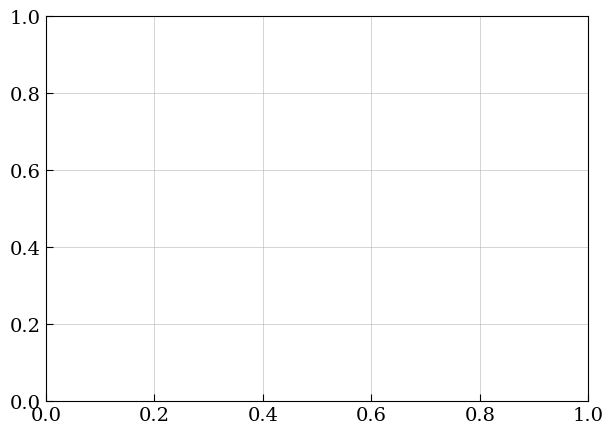

In [6]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(np.asarray(loss_history), '-o', markersize=3, markeredgecolor='k')
ax.set_xlabel('training iterations')
ax.set_ylabel('loss', fontsize=16)
ax.set_title('Loss Throughout Training', fontsize=14)
#ax.set_ylim([0, 50])
plt.minorticks_on()
#ax.set_xscale('log')
plt.show()

In [28]:
problem = cl.Problem(
    num_qubits,
    drop_phase_bits=drop_phase_bits,
    seed=11
    #initial_state=cl.sequence_to_tableau([], num_qubits)
    )

result = cl.hillclimbing(
    problem.state,
    lgf_model,
    max_iter=1000,
    seed=123,
    )

In [29]:
result['success']

True

9

[(0, 1, 'cx'),
 (2, 0, 'cx'),
 (2, 0, 'cx'),
 (0, 1, 'cx'),
 (0, 1, 'cx'),
 (0, 1, 'cx')]

In [ ]:
num_qubits, drop_phase_bits

(3, True)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [12]:
if problem.drop_phase_bits:
    if np.array_equal(1*problem.state.tableau[:,:-1], np.eye(2*problem.num_qubits)):
        print('yes')

yes


In [ ]:
num_trials = 1000
max_iter = 1000

## using the LGF
steps_until_success = cl.compute_weighted_steps_until_success(
    lgf_model=lgf_model,
    weight_dict=weight_dict,
    num_trials=num_trials, 
    max_iter=max_iter
    )

## applying a purely random move
steps_until_success_random = cl.compute_weighted_steps_until_success(
    lgf_model=lgf_model, 
    weight_dict=weight_dict,
    num_trials=num_trials, 
    max_iter=max_iter,
    method='random'
    )

## use qiskit method
steps_until_success_qiskit = cl.compute_weighted_steps_until_success(
    lgf_model=lgf_model, 
    weight_dict=weight_dict,
    num_trials=num_trials, 
    max_iter=max_iter,
    method='qiskit'
    )

In [ ]:
from importlib import reload
reload(cl)

In [ ]:
cum_steps_utils_success = np.sort([n for n in steps_until_success if n is not None])
cum_steps_utils_success_random = np.sort([n for n in steps_until_success_random if n is not None])
cum_steps_utils_success_qiskit = np.sort(steps_until_success_qiskit)

fig, ax = plt.subplots(figsize=(7,5))
ax.step(
    cum_steps_utils_success, 
    np.arange(len(cum_steps_utils_success))/len(steps_until_success), 
    label='LGF'
    )
ax.step(
    cum_steps_utils_success_random, 
    np.arange(len(cum_steps_utils_success_random))/len(steps_until_success_random), 
    label='Random'
    )
ax.step(
    cum_steps_utils_success_qiskit, 
    np.arange(len(cum_steps_utils_success_qiskit))/len(steps_until_success_qiskit), 
    label='Qiskit'
    )
ax.set_xscale('log')
ax.set_xlabel('Weighted Hillclimbing Distance')
ax.set_ylabel('Fraction of Instances Solved')
ax.set_title(f'n={lgf_model.num_qubits} qubits')
plt.legend()
plt.minorticks_on()
plt.show()

In [ ]:
Ntrials = 1000
distance = {'qiskit':[], 'lgf':[]}
k = 0

for n in tqdm.trange(Ntrials):

    while True:
        #x = random_clifford(num_qubits, seed=k)
        x = cl.Problem(num_qubits, seed=k).state
        result = cl.hillclimbing(
            x,
            lgf_model,
            max_iter=1000,
            seed=k
            )
        k += 1
        if result['success']:
            #print('success, k=%i' %k)
            break

    distance['qiskit'].append(
        cl.weighted_distance_to_identity(
        synth_clifford_full(x), 
        weight_dict)
        )
    distance['lgf'].append(
        cl.weighted_distance_to_identity(
        result['move_history'], 
        weight_dict)
        )

In [ ]:
x = np.mean([distance['qiskit'][i] > distance['lgf'][i] for i in range(len(distance['qiskit']))])
print('fraction of instances where lgf method beat matches qiskit: %.4f' %x)

x = np.mean([distance['qiskit'][i] >= distance['lgf'][i] for i in range(len(distance['qiskit']))])
print('fraction of instances where lgf method beats or matches qiskit: %.4f' %x)